In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import itertools
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [37]:
# Load the dataset
train = pd.read_csv('/kaggle/input/ecommerce-demand-forecasting-dataset/train.csv', parse_dates=['date'])

# Preprocessing: Focus on Store 1, Item 1
data = train[(train['store'] == 1) & (train['item'] == 1)].sort_values('date')
# Keep 'data' intact for now; only create 'ts' as a separate Series
ts = data.set_index('date')['sales']
# 'data' still has 'date' as a column for later use

## Exploratory Data Analysis - Basic Info

In [38]:
# Basic dataset info and statistics
print("Dataset Info:")
print(data.info())
print("\nDescriptive Statistics:")
print(data['sales'].describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1826 non-null   datetime64[ns]
 1   store   1826 non-null   int64         
 2   item    1826 non-null   int64         
 3   sales   1826 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 71.3 KB
None

Descriptive Statistics:
count    1826.000000
mean       19.971522
std         6.741022
min         4.000000
25%        15.000000
50%        19.000000
75%        24.000000
max        50.000000
Name: sales, dtype: float64


## EDA - Time Series Plot

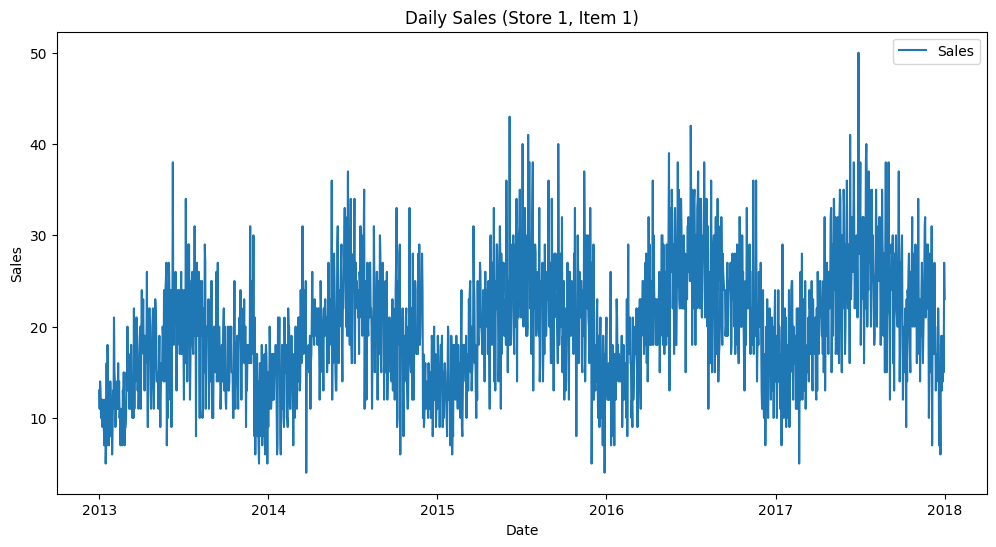

In [39]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Sales')
plt.title('Daily Sales (Store 1, Item 1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## EDA - Seasonal Decomposition

<Figure size 1200x1000 with 0 Axes>

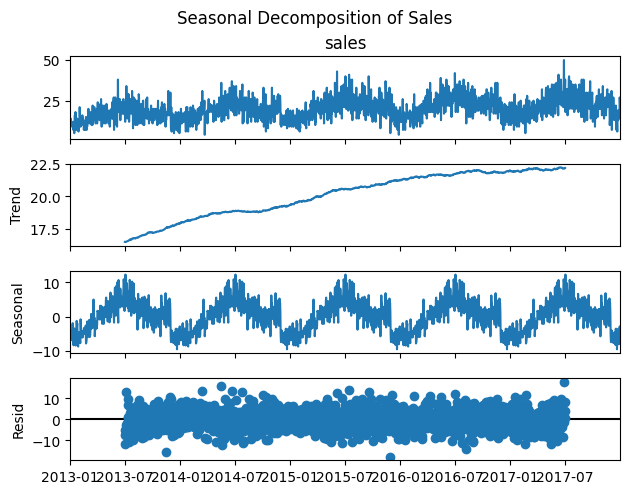

In [40]:
# Seasonal Decomposition
decomp = seasonal_decompose(ts, model='additive', period=365)
plt.figure(figsize=(12, 10))
decomp.plot()
plt.suptitle('Seasonal Decomposition of Sales', y=1.02)
plt.show()

## EDA - Autocorrelation Plot

<Figure size 1200x600 with 0 Axes>

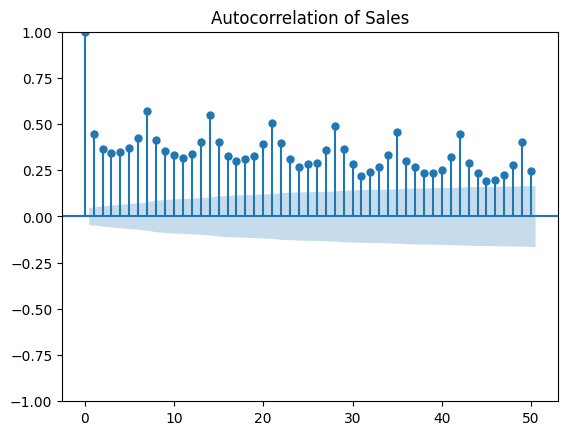

In [41]:
# Autocorrelation Plot
plt.figure(figsize=(12, 6))
plot_acf(ts, lags=50)
plt.title('Autocorrelation of Sales')
plt.show()

## EDA - Sales Distribution

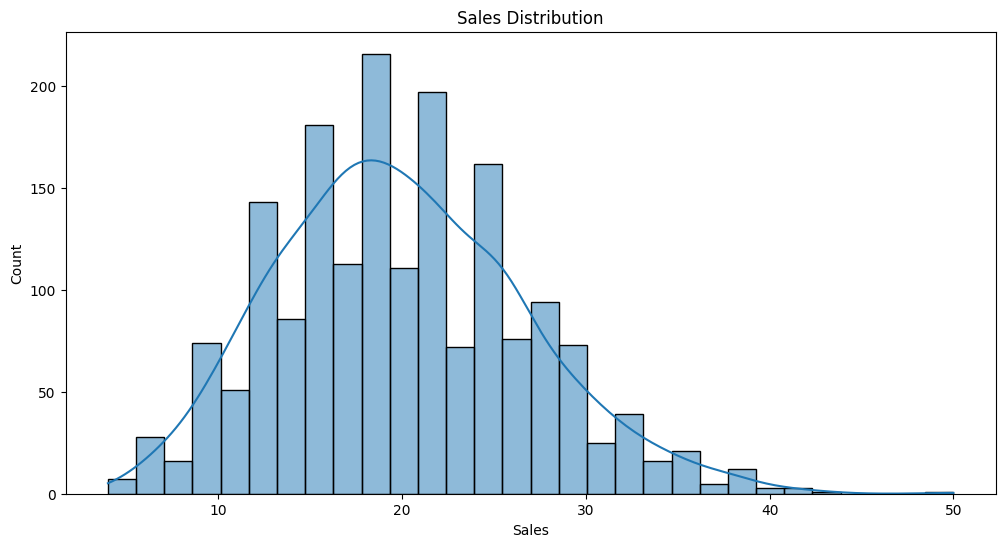

In [42]:
# Sales Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data['sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.show()

## EDA - Monthly Sales Trend

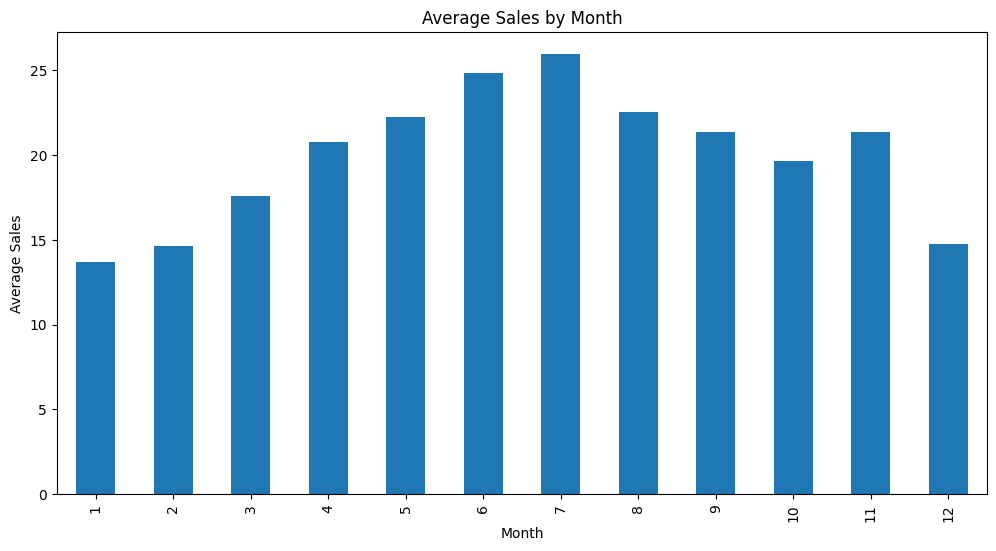

In [43]:
# Monthly Sales Trend
data['month'] = data['date'].dt.month
monthly_sales = data.groupby('month')['sales'].mean()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

## Feature Engineering

In [44]:
# Feature Engineering
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['lag_7'] = data['sales'].shift(7)  # 7-day lag
data['rolling_mean_7'] = data['sales'].rolling(window=7).mean()  # 7-day rolling mean
data['is_holiday'] = data['date'].isin(['2017-12-25', '2016-12-25', '2015-12-25']).astype(int)  # Synthetic holiday flag

# Drop NaN values from feature engineering
data = data.dropna()

# Set index explicitly to ensure alignment
data = data.set_index('date')
ts = data['sales']
exog = data[['day_of_week', 'month', 'lag_7', 'rolling_mean_7', 'is_holiday']].astype(float)

# Verify alignment
print("ts and exog index alignment check:")
print(ts.index.equals(exog.index))  # Should print True

ts and exog index alignment check:
True


## Train-Test Split

In [46]:
# Train-test split (last 90 days as test)
train_ts = ts[:-90]
test_ts = ts[-90:]
train_exog = exog.loc[train_ts.index]  # Ensure exog aligns with train_ts index
test_exog = exog.loc[test_ts.index]    # Ensure exog aligns with test_ts index

# Verify alignment after split
print("train_ts and train_exog alignment:", train_ts.index.equals(train_exog.index))  # Should print True
print("test_ts and test_exog alignment:", test_ts.index.equals(test_exog.index))     # Should print True

train_ts and train_exog alignment: True
test_ts and test_exog alignment: True


## ARIMA Model with Grid Search

In [47]:
# 1. ARIMA Model with Grid Search
# Define parameter ranges
p = d = q = range(0, 3)  # Small range for simplicity
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_arima_fit = None

# Grid search
for order in pdq:
    try:
        model = ARIMA(train_ts, order=order)
        fit = model.fit()
        if fit.aic < best_aic:
            best_aic = fit.aic
            best_order = order
            best_arima_fit = fit
    except:
        continue

print(f'Best ARIMA Order: {best_order} with AIC: {best_aic}')
arima_pred = best_arima_fit.forecast(steps=90)
arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_pred))
print(f'ARIMA RMSE: {arima_rmse}')

Best ARIMA Order: (2, 1, 1) with AIC: 10724.845042440546
ARIMA RMSE: 6.561306279198894


## Plot ARIMA vs Actual


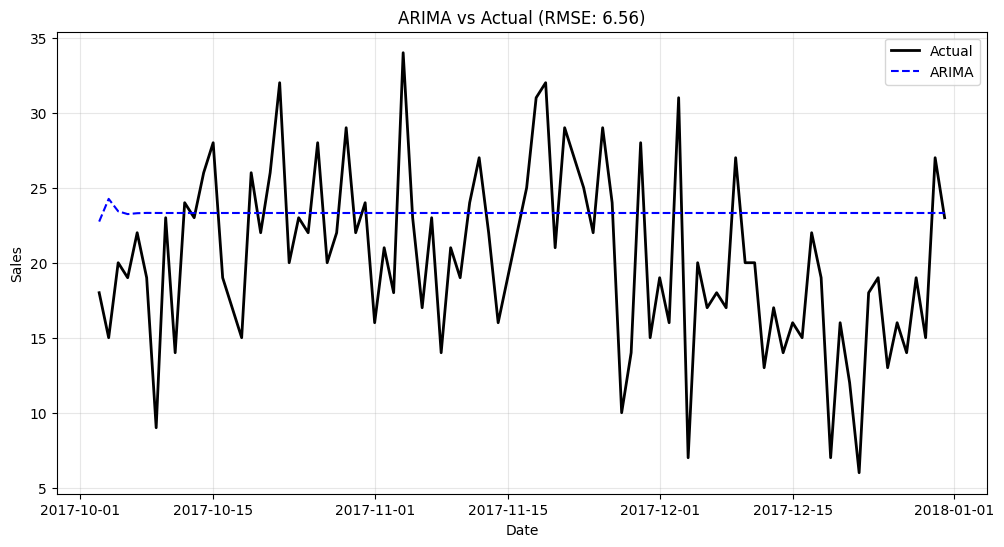

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, arima_pred, label='ARIMA', color='blue', linestyle='--')
plt.title(f'ARIMA vs Actual (RMSE: {arima_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## SARIMA Model

In [48]:
# 2. SARIMA Model with Grid Search
# Define parameter ranges
p = d = q = range(0, 2)  # Smaller range for computational efficiency
P = D = Q = [0, 1]  # Seasonal parameters
m = 7  # Weekly seasonality
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(P, D, Q))]

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_sarima_fit = None

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train_ts, order=param, seasonal_order=seasonal_param)
            fit = model.fit(disp=False)
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_sarima_fit = fit
        except:
            continue

print(f'Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order} with AIC: {best_aic}')
sarima_pred = best_sarima_fit.forecast(steps=90)
sarima_rmse = np.sqrt(mean_squared_error(test_ts, sarima_pred))
print(f'SARIMA RMSE: {sarima_rmse}')

Best SARIMA Order: (1, 0, 1), Seasonal Order: (0, 1, 1, 7) with AIC: 10220.427479624213
SARIMA RMSE: 5.565017895388199


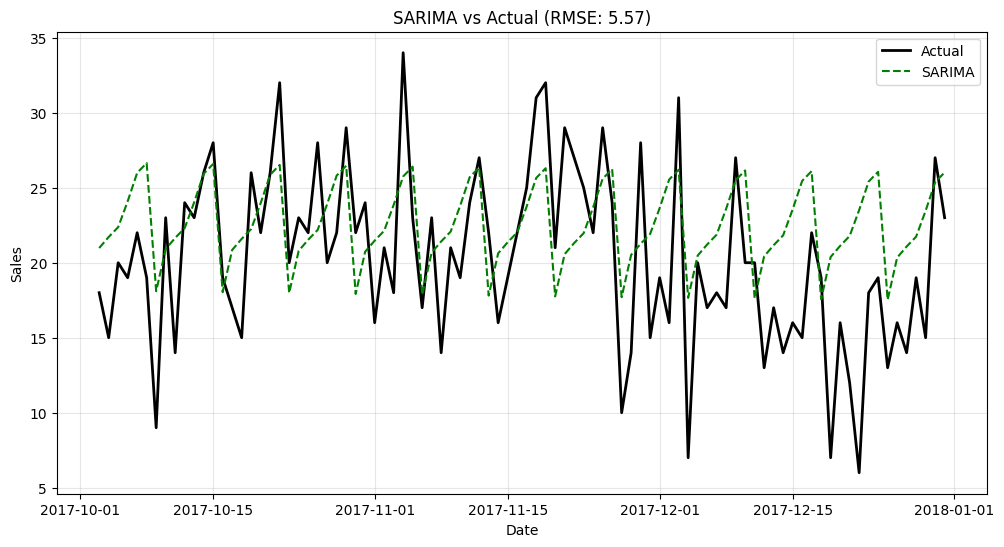

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, sarima_pred, label='SARIMA', color='green', linestyle='--')
plt.title(f'SARIMA vs Actual (RMSE: {sarima_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ARIMAX Model

In [49]:
# 3. ARIMAX Model (using best ARIMA order from grid search)
arimax_model = ARIMA(train_ts, order=best_order, exog=train_exog)
arimax_fit = arimax_model.fit()
arimax_pred = arimax_fit.forecast(steps=90, exog=test_exog)
arimax_rmse = np.sqrt(mean_squared_error(test_ts, arimax_pred))
print(f'ARIMAX RMSE: {arimax_rmse}')

ARIMAX RMSE: 4.095690163987292


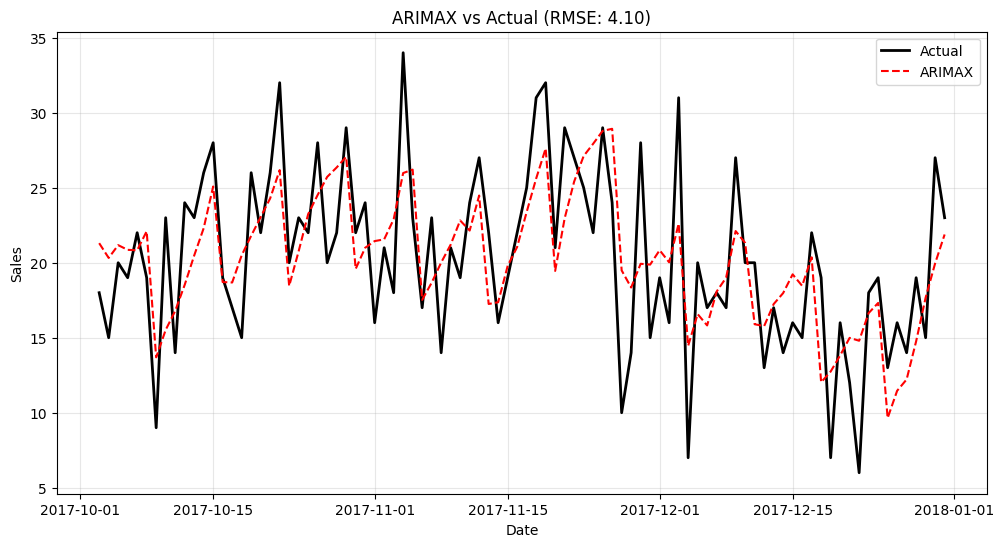

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, arimax_pred, label='ARIMAX', color='red', linestyle='--')
plt.title(f'ARIMAX vs Actual (RMSE: {arimax_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## SARIMAX Model

In [50]:
# 4. SARIMAX Model (using best SARIMA orders from grid search)
sarimax_model = SARIMAX(train_ts, order=best_order, seasonal_order=best_seasonal_order, exog=train_exog)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.forecast(steps=90, exog=test_exog)
sarimax_rmse = np.sqrt(mean_squared_error(test_ts, sarimax_pred))
print(f'SARIMAX RMSE: {sarimax_rmse}')

SARIMAX RMSE: 4.115823686068236


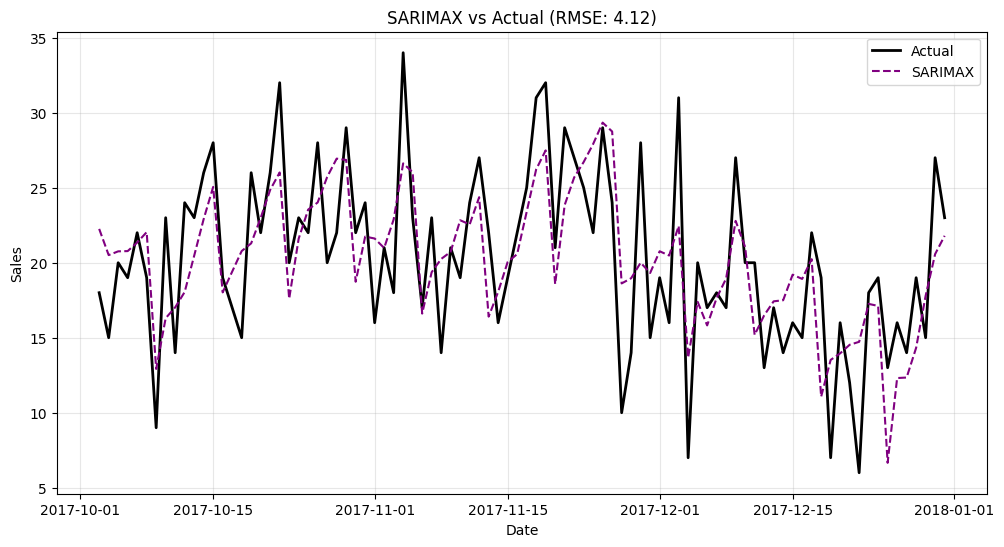

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, sarimax_pred, label='SARIMAX', color='purple', linestyle='--')
plt.title(f'SARIMAX vs Actual (RMSE: {sarimax_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Linear Regression


In [51]:
lr = LinearRegression()
lr.fit(train_exog, train_ts)
lr_pred = lr.predict(test_exog)
lr_rmse = np.sqrt(mean_squared_error(test_ts, lr_pred))
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 4.079461575178827


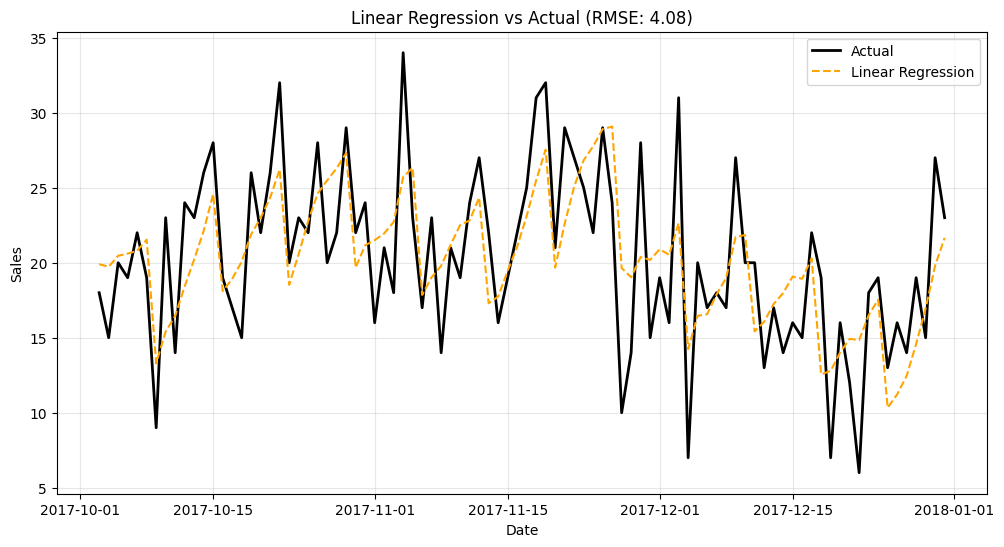

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, lr_pred, label='Linear Regression', color='orange', linestyle='--')
plt.title(f'Linear Regression vs Actual (RMSE: {lr_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 ## Logistic Regression Model

In [52]:
# 6. Logistic Regression (binarize sales: above/below median)
median_sales = train_ts.median()
train_y_bin = (train_ts > median_sales).astype(int)
test_y_bin = (test_ts > median_sales).astype(int)
logit = LogisticRegression()
logit.fit(train_exog, train_y_bin)
logit_pred = logit.predict(test_exog)
logit_accuracy = (logit_pred == test_y_bin).mean()
print(f'Logistic Regression Accuracy: {logit_accuracy}')

Logistic Regression Accuracy: 0.7888888888888889


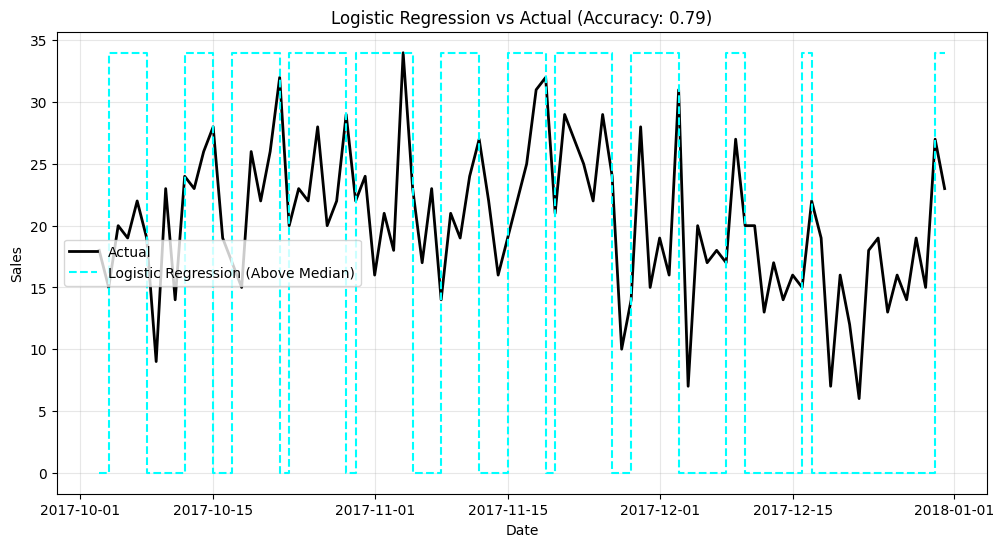

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.step(test_ts.index, logit_pred * test_ts.max(), label='Logistic Regression (Above Median)', color='cyan', linestyle='--')
plt.title(f'Logistic Regression vs Actual (Accuracy: {logit_accuracy:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## XGBoost Model

In [53]:
# 7. XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(train_exog, train_ts)
xgb_pred = xgb.predict(test_exog)
xgb_rmse = np.sqrt(mean_squared_error(test_ts, xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost RMSE: 4.367368104359416


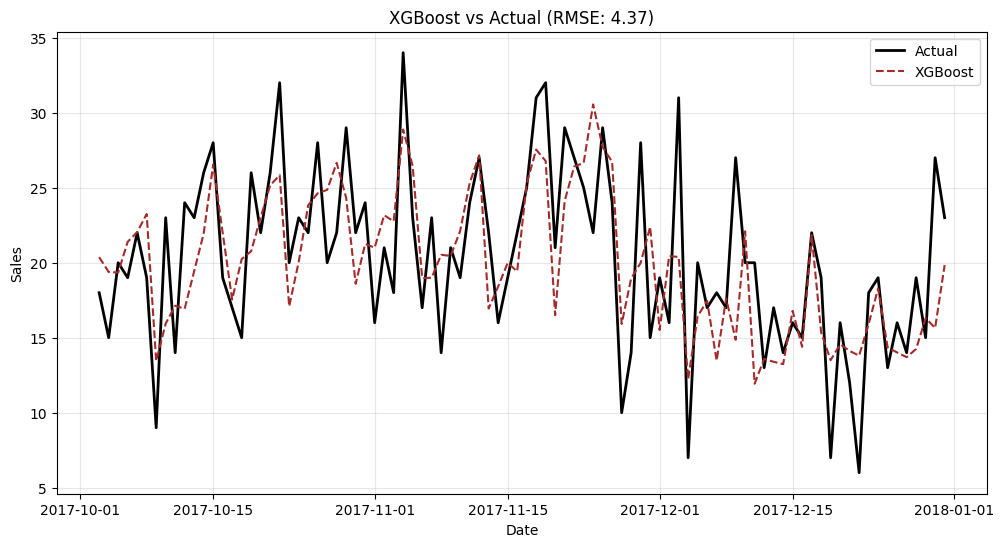

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, xgb_pred, label='XGBoost', color='brown', linestyle='--')
plt.title(f'XGBoost vs Actual (RMSE: {xgb_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Ensemble Model

In [64]:
# 8. Ensemble (Average of SARIMAX and XGBoost)
ensemble_pred = (sarimax_pred + arimax_pred + arima_pred) / 3
ensemble_rmse = np.sqrt(mean_squared_error(test_ts, ensemble_pred))
print(f'Ensemble RMSE: {ensemble_rmse}')

Ensemble RMSE: 4.413083527467591


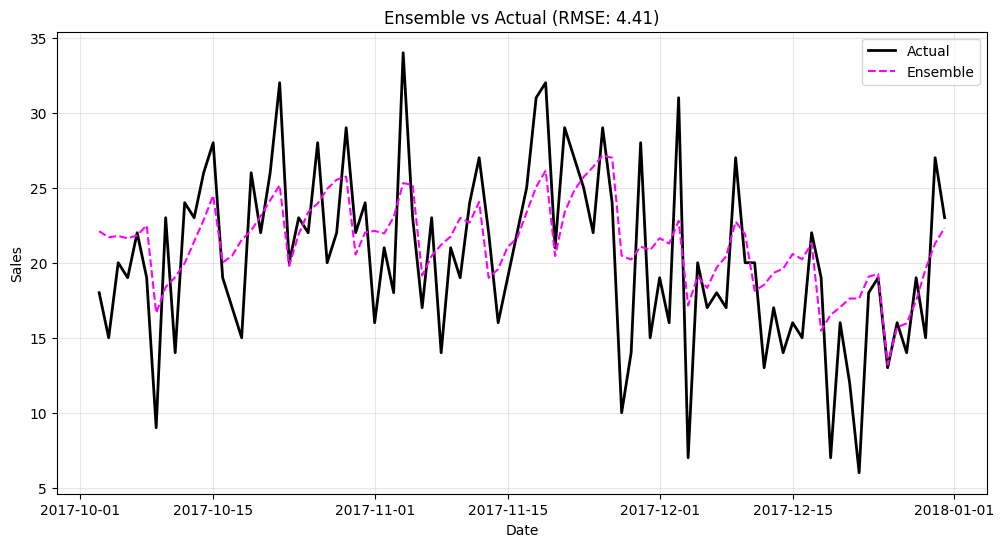

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, ensemble_pred, label='Ensemble', color='magenta', linestyle='--')
plt.title(f'Ensemble vs Actual (RMSE: {ensemble_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Forecast Comparision Plot

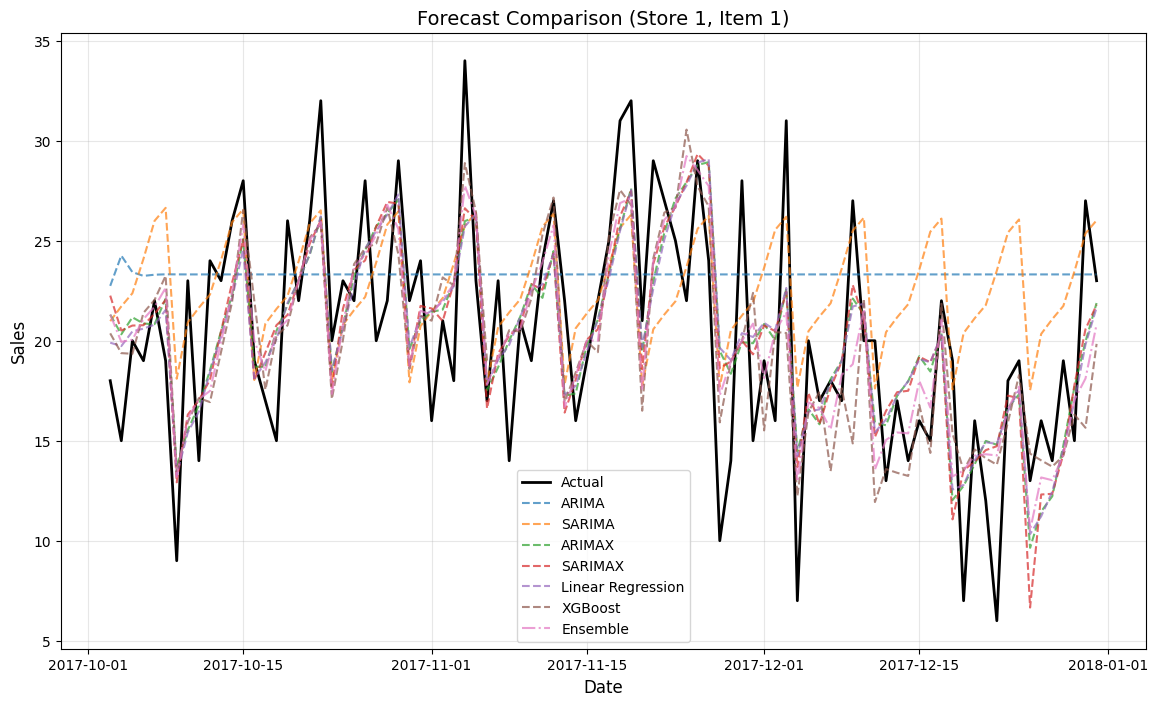

In [55]:
# Forecast Comparison Plot
plt.figure(figsize=(14, 8))
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=2)
plt.plot(test_ts.index, arima_pred, label='ARIMA', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, sarima_pred, label='SARIMA', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, arimax_pred, label='ARIMAX', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, sarimax_pred, label='SARIMAX', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, lr_pred, label='Linear Regression', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, xgb_pred, label='XGBoost', alpha=0.7, linestyle='--')
plt.plot(test_ts.index, ensemble_pred, label='Ensemble', alpha=0.7, linestyle='-.')
plt.title('Forecast Comparison (Store 1, Item 1)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()